<a href="https://colab.research.google.com/github/kolattukudy/InteractiveBrokers-PairsTrading-Algo/blob/master/NewYahoo_Equity_Option_Implied_Volatility_Analytics_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Equity Option Implied Volatility Analytics with Python

View the [talk](https://www.youtube.com/watch?v=RETxgJcXBAY).

Python has become an increasingly important tool in the domain of quantitative and algorithmic trading and research. Users range from senior quantitative analysts and researchings pricing complex derivatives using numerical techniques all the way to the retail trader just getting started. This talk will cover the basics of pricing "plain vanilla" options on listed equities and dive into some analysis of the unobserved feature of listed equity options known as implied volatility.

In this talk, we'll learn a bit about Black-Scholes model, the derived option pricing formula and the "greeks" and how to code it all in Python. I'll then demonstrate how to gather options data using Pandas and apply various transformations to obtain the theoretical value of the option and the associated greeks. We'll then extend the talk to discuss implied volatility and show how to use Numpy methods to compute implied volatility and model missing and bad values using interpolation. Finally, we'll use the results to visualize the so-called volatility skew and term structure to help inform potential trading decisions.

# About me

I studied finance, economics and computer science during my undergraduate coursework in the US. In graduate school I studied quantitative finance and trading, graduating with a Master of Science in Finance. I traded interest rate derivatives for a hedge fund in Chicago, worked for JPMorgan in Chicago, BP in London and am now APAC CIO at a global agricultural trading firm in Singaore.

Because CIO has nothing to do with technology, I code in my free time.

I'm online:

* [LinkedIn](https://sg.linkedin.com/in/jasonstrimpel)
* [Twitter](https://twitter.com/jasonstrimpel)
* [Github](https://github.com/jasonstrimpel)
* [Blog](http://www.bespokeoptions.com/blog)
* [Meetup](http://www.meetup.com/members/37553102/)
* [Finance Tools](http://finance.jasonstrimpel.com)
* [PyQuant News](http://www.pyquantnews.com)


# Important jargon

Let's start with the vocabulary.

### Terms to know

* __Call option__. Derivative contract which conveys the right (not the obligation) to the buyer of the option to purchase the underlying stock at a specific price on a certain date.

* __Put option__. Derivative contract which conveys the right (not the obligation) to the buyer of the option to sell the underlying stock at a specific price on a certain date.

* __In the money__. Condition where the stock price is greater than the strike price for a call option or lower than the strike price for a put option

* __Out the money__. Opposite of in the money.

* __At the money__. The stock price is equal to the strike price.

* __Implied volatility__. Volatiltiy parameter that sets the pricing model equal to the market price of the option. (Much more on this later.)

### Input parameters to price options

Options priced with Black-Scholes have five input variables, four of which can be observed in the market and one of which is latent (unobservable, more on this later).

* __Underlying stock price ($S$)__. Price of the underlying stock upon which the option derives its value.

* __Strike price ($K$)__. The price at which the owner of the option can buy the underlying in the case of a call or sell the underlying in the case of a put.

* __Time to expiration ($t$)__. Time (as a fraction of a 365 day year) until the expiration of the option.

* __Risk free rate ($r$)__. So-called risk free rate (this is better described as the rate of interest you would earn in a riskless security over the holding period of the option)

* __Volatility ($vol$)__. Volatility (or more usually implied volatility) is a latent value not actually observed in the market.

Let's import our modules and declare these variables in Python for later use.

In [2]:
# magic function to plot inline
%matplotlib inline

# python standard modules
import time
import datetime as dt
from math import sqrt, pi


# import numpy, pyplot and scipy
import numpy as np
import matplotlib as mat
mat.style.use('ggplot')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# import pandas
import pandas
# new in 0.17.1
from pandas_datareader import data as pd


print 'Numpy %s\nMatplotlib %s\nScipy %s\nPandas %s' % \
    (np.__version__, mat.__version__, scipy.__version__, pandas.__version__)

# underlying stock price
S = 45.0

# series of underlying stock prices to demonstrate a payoff profile
S_ = np.arange(40.0, 50.0, 0.01)

# strike price
K = 45.0

# time to expiration (you'll see this as T-t in the equation)
t = 164.0/365.0

# risk free rate (there's nuance to this which we'll describe later)
r = 0.02

# volatility (latent variable which is the topic of this talk)
vol = 0.25

Numpy 1.16.4
Matplotlib 2.2.4
Scipy 1.2.2
Pandas 0.24.2


# What are options?

Options are standardized derivatives contracts that convey the buyer the right (but not obligation) to buy the underlying security in the case of a call option or sell the underlying security in the case of a put option at a given price before a given date (for American style options) or on a given date (European style options).

There are many types of options of which only a few are available for retail traders. "[Exotics](https://en.wikipedia.org/wiki/Exotic_option)" exist that are generally large dollar trades (millions of US$) and traded among investment banks. These are generally custom built by quants to help solve a customer's specific financial problem.

We will focus on plain vanilla, european style, equity options so we can use the famous Black-Scholes pricing formula. More on Black-Scholes a bit later.

Most derivatives have a payoff function which describes the value at the end of the life of the contract (expiration). For a call option, the payoff can be expressed simply as:

> $$C(S, K) = max(S-K, 0)$$

While the payoff for a put option can be expressed as:

> $$P(K, S) = max(K-S, 0)$$

Where $S$ and $K$ are defined above. In this case, $K$ remains fixed during the life of a contract while the underlying stock price, $S$, fluctuates..

Across a range of potential $S$ values, we can form what is commonly known as the payoff (or risk profile or PnL chart) for an option at expiration.

The challenge for quants is to figure out what the price of the option is *before* expiration. This is where option pricing models like Black-Scholes come into play.

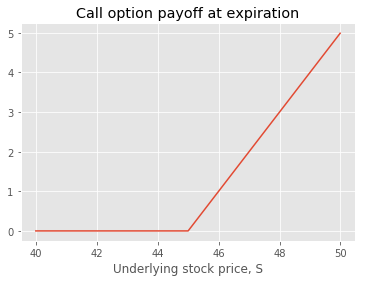

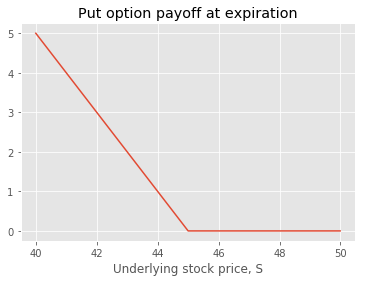

In [3]:
# use a lambda for a call payoff function
# equivelant to:
#
# def call_payoff(S, K):
#     return np.maximum(S - K, 0.0)
call_payoff = lambda S, K: np.maximum(S_ - K, 0.0)

# and put payoff function
put_payoff = lambda S, K: np.maximum(K - S_, 0.0)

# plot the call payoff 
plt.figure(1)
plt.title('Call option payoff at expiration')
plt.xlabel('Underlying stock price, S')
plt.plot(S_, call_payoff(S_, K))

# plot the put payoff
plt.figure(2)
plt.title('Put option payoff at expiration')
plt.xlabel('Underlying stock price, S')
plt.plot(S_, put_payoff(S_, K))

# What is the Black-Scholes option pricing model?

Black-Scholes is largely understood as an options pricing formula but it is really a framework that models a financial market. Within this framework the options pricing formula is be derived through stochasitc differentiation.

The Black–Scholes model assumes that the market consists of at least one risky asset, usually called the stock, and one riskless asset, usually called the money market, cash, or bond.

Assumptions on the market:

* The rate of return on the riskless asset is constant and thus called the risk-free interest rate
* The instantaneous log returns of the stock price is an infinitesimal random walk with drift and volatility (geometric Brownian motion) and assumes this drift and volatility are constant
* The stock does not pay a dividend

Assumptions on the underlying security:

* There is no arbitrage opportunity (i.e. there is no way to make a riskless profit)
* It is possible to borrow and lend any amount, even fractional, of cash at the riskless rate
* It is possible to buy and sell any amount, even fractional, of the stock (this includes short selling)
* The above transactions do not incur any fees or costs (i.e. frictionless market).

As any trader knows, not a single one of these assumptions are actually true in reality. Probably the most imporant is the assumption of constant volatility which motivates this presentation.

Assume these assumptions *do* hold and suppose there is a derivative security also trading in this market. We specify that this security will have a certain payoff at a specified date in the future, depending on the value(s) taken by the stock up to that date. It is a surprising fact that the derivative's price is completely determined at the current time, even though we do not know what path the stock price will take in the future. (These are the payoffs we saw above.) For the special case of a European call or put option, Black and Scholes showed that *"it is possible to create a hedged position, consisting of a long position in the stock and a short position in the option, whose value will not depend on the price of the stock"*. Their dynamic hedging strategy led to a partial differential equation which governed the price of the option. Its solution is given by the Black–Scholes formula.

Source: https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model


# (Some of) the math

The famous Black-Scholes model:

> $$\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^{2}S^{2}\frac{\partial^{2} V}{\partial S^{2}}+rS\frac{\partial V}{\partial S}-rV=0$$

The key financial insight behind the equation is that one can perfectly hedge the option by buying and selling the underlying asset in just the right way and consequently create an arbitrage free environment. This hedge, in turn, implies that there is only one right price for the option, as returned by the Black–Scholes formula. For this dynamic hedging to work, one must continuously hedge the movement in the underlying stock with the option which in reality, is prohibitive due to transaction costs.

I'll skip the derivation of the option pricing formulas from the partial differential equation but the result solves for a call option

> $$C(S, t) = N(d_{1})S - N(d_{2})Ke^{-r(T-t)}$$

and put option

> $$P(S, t) = N(-d_{2})Ke^{-r(T-t)} - N(-d_{1})S$$

where

> $$d_{1} = \frac{ln(\frac{S}{K})+(r+\frac{\sigma^{2}}{2})(T-t)}{\sigma\sqrt{T-t}}$$

and

> $$d_{2} = d_{1} - \sigma\sqrt{T-t}$$

and finally (as we discussed above)

* $N(\cdot)$ is the cumulative distribution function of the standard normal distribution
* $T - t$ is the time to maturity (I use $t$ in the code)
* $S$ is the spot price of the underlying asset
* $K$ is the strike price
* $r$ is the risk free rate (annual rate, expressed in terms of continuous compounding)
* $\sigma$ is the volatility of returns of the underlying asset (I use $vol$ in the code)

# Black-Scholes formula in Python

Finally, enough math and some code. We'll be using Numpy so we vectorize the function which will help us later.

In [4]:
def N(z):
    """ Normal cumulative density function

    :param z: point at which cumulative density is calculated 
    :return: cumulative density under normal curve
    """
    return norm.cdf(z)


def black_scholes_call_value(S, K, r, t, vol):
    """ Black-Scholes call option

    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: BS call option value
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    return N(d1) * S - N(d2) * K * np.exp(-r * t)

def black_scholes_put_value(S, K, r, t, vol):
    """ Black-Scholes put option

    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: BS put option value
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    return N(-d2) * K * np.exp(-r * t) - N(-d1) * S


In [5]:
print 'Black-Scholes call value %0.2f' % black_scholes_call_value(S, K, r, t, vol)
print 'Black-Scholes put value %0.2f' % black_scholes_put_value(S, K, r, t, vol)

Black-Scholes call value 3.20
Black-Scholes put value 2.79


Because we vectorized the function, we can plot the Black-Scholes call value along a range of underlying stock prices. Going back to our example of the option value at expiration, let's see what it looks like with six, three and one month left to expiration.

In [6]:
# get the value of the option with six months to expiration
black_scholes_call_value_six_months = black_scholes_call_value(S_, K, r, 0.5, vol)

# get the value of the option with three months to expiration
black_scholes_call_value_three_months = black_scholes_call_value(S_, K, r, 0.25, vol)

# get the value of the option with one month to expiration
black_scholes_call_value_one_month = black_scholes_call_value(S_, K, r, 1.0/12.0, vol)

# get payoff value at expiration
call_payoff_at_expiration = call_payoff(S_, K)

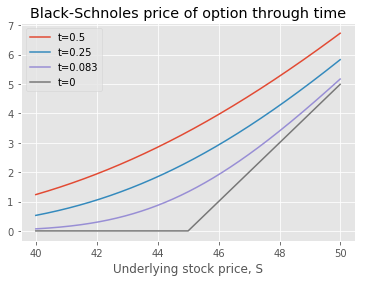

In [7]:
# plot the call payoffs
plt.figure(3)
plt.plot(S_, black_scholes_call_value_six_months)
plt.plot(S_, black_scholes_call_value_three_months)
plt.plot(S_, black_scholes_call_value_one_month)
plt.plot(S_, call_payoff_at_expiration)
plt.title('Black-Schnoles price of option through time')
plt.xlabel('Underlying stock price, S')
plt.legend(['t=0.5', 't=0.25', 't=0.083', 't=0'], loc=2)

As you can see from the plot above, as the time to expiration decreases, the value of the option collapses towards the value of the option at expiration, or the payoff value.

# The Greeks

A discussion about Black-Scholes would not be complete without a discussion of the Greeks. In mathematical terms, the Greeks are simply the partial derivatives of the option pricing formula. In other words, these are the sensitivities in the movement of the option price relative to the movement of other aspects of the input variables.

Because the assumptions required for the Black-Scholes model do not hold true in practice, the plain vanilla formula presented above is not usually used for pricing options for the purposes of trading. (In fact if one were to rely on Black-Scholes to manage a portfolio of options, that trader would surely lose money.) It is however, largely used for understanding the sensitivities of the option with respect to it's parameters and to hedge. The most common Greeks are as follows.

* **Delta**. Partial derivative of the option value with respect to the change in the underlying stock price. Delta measures how the underlying option moves with respect to moves in the underlying stock. The formula for delta is different for calls and puts.

> Call delta
> $$\frac{\partial V}{\partial S} = N(d_{1})$$

> Put delta
> $$\frac{\partial V}{\partial S} = N(d_{1})-1$$

* **Gamma**. Second partial derivative of the option value with respect to the change in the underlying stock price. Gamma measures movements in delta or the convexity in the value of the option with respect to the underlying.

> Gamma (same for call and put)
> $$\frac{\partial^2 V}{\partial S^2} = \frac{\phi(d_{1})}{S\sigma \sqrt{T-t}}$$

* **Vega**. Partial derivative of the option value with respect to the change in the volatility of the underling. Vega measures how the option price moves with respect to the volatility of the underlying. (Note vega is not a real greek letter.)

> Vega (same for call and put)
> $$\frac{\partial V}{\partial \sigma} = S\phi(d_{1}) \sqrt{T-t}$$

* **Theta**. Partial derivative of the option value with respect to the change in time. Theta measures how the value of the option decays as time passes. This was demonstrated in the plot above.

> Call theta
> $$\frac{\partial V}{\partial t} = -\frac{S\phi(d_{1})\sigma}{2\sqrt{T-t}} -rKe^{-r(T-t)}N(d_2)$$

> Put theta
> $$\frac{\partial V}{\partial t} = -\frac{S\phi(d_{1})\sigma}{2\sqrt{T-t}} +rKe^{-r(T-t)}N(-d_2)$$

* **Rho**. Partial derivative of the option value with respect to change in the risk-free interest rate. Rho measures how the option value changes as the interest rate changes.

> Call rho
> $$\frac{\partial V}{\partial r} = K(T-t)e^{-r(T-t)}N(d_2)$$

> Put rho
> $$\frac{\partial V}{\partial r} = -K(T-t)e^{-r(T-t)}N(-d_2)$$

Where $\phi$

> $$\phi(x) = \frac{e^{-\frac{x^2}{2}}}{\sqrt{2\pi}}$$

and $N(\cdot)$, $d_1$ and $d_2$ are defined above.

# The greeks in Python

Although we won't be discussing the greeks any further in this talk, let's code them up for completeness.

In [8]:
def phi(x):
    """ Phi helper function
    
    """
    return np.exp(-0.5 * x * x) / (sqrt(2.0 * pi))

def call_delta(S, K, r, t, vol):
    """ Black-Scholes call delta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call delta
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    
    return N(d1)

def put_delta(S, K, r, t, vol):
    """ Black-Scholes put delta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put delta
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    
    return N(d1) - 1.0

def gamma(S, K, r, t, vol):
    """ Black-Scholes gamma
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: gamma
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    
    return phi(d1) / (S * vol * sqrt(t))

def vega(S, K, r, t, vol):
    """ Black-Scholes vega
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: vega
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    
    return (S * phi(d1) * sqrt(t)) / 100.0

def call_theta(S, K, r, t, vol):
    """ Black-Scholes call theta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call theta
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    theta = -((S * phi(d1) * vol) / (2.0 * np.sqrt(t))) - (r * K * np.exp(-r * t) * N(d2))
    return theta / 365.0

def put_theta(S, K, r, t, vol):
    """ Black-Scholes put theta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put theta
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    theta = -((S * phi(d1) * vol) / (2.0 * np.sqrt(t))) + (r * K * np.exp(-r * t) * N(-d2))
    return theta / 365.0

def call_rho(S, K, r, t, vol):
    """ Black-Scholes call rho
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call rho
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    rho = K * t * np.exp(-r * t) * N(d2)
    return rho / 100.0

def put_rho(S, K, r, t, vol):
    """ Black-Scholes put rho
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put rho
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    rho = -K * t * np.exp(-r * t) * N(-d2)
    return rho / 100.0

In [9]:
# print each of the results
print 'Black-Scholes call delta %0.4f' % call_delta(S, K, r, t, vol)
print 'Black-Scholes put delta %0.4f' % put_delta(S, K, r, t, vol)
print 'Black-Scholes gamma %0.4f' % gamma(S, K, r, t, vol)
print 'Black-Scholes vega %0.4f' % vega(S, K, r, t, vol)
print 'Black-Scholes call theta %0.4f' % call_theta(S, K, r, t, vol)
print 'Black-Scholes put theta %0.4f' % put_theta(S, K, r, t, vol)
print 'Black-Scholes call rho %0.4f' % call_rho(S, K, r, t, vol)
print 'Black-Scholes put rho %0.4f' % put_rho(S, K, r, t, vol)

Black-Scholes call delta 0.5546
Black-Scholes put delta -0.4454
Black-Scholes gamma 0.0524
Black-Scholes vega 0.1192
Black-Scholes call theta -0.0103
Black-Scholes put theta -0.0078
Black-Scholes call rho 0.0978
Black-Scholes put rho -0.1026


# Implied volatility

The Black-Scholes pricing formula is usually used to solve for implied volatility. Quite simply, this means setting the Black-Scholes pricing formula equal to the market observed price and using a root finding algorithm to solve for the volatility parameter which sets the difference (between model and market price) to zero.

The implied volatility is generally used for making trading decisions, calibrating other more exotic securities and researching market anomolies. For example, many traders use the so called volatility skew to understand the relative value of an option to other options trading in the market. We'll see examples of the skew later.

In the first of a two part [blog](http://www.bespokeoptions.com/blog/2015/10/06/implied-volatility-with-c-and-python-pt-1) series, I've discussed how to use C++ to find implied volatility. Here, we will use pure Python.

First we create an objective function which we'll pass to the Scipy implementation of the [Brentq algorithm](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.brentq.html). Then we'll create an implied volatilty function to return the volatility parameter that sets the observed market price to the model price.

In [10]:
def call_implied_volatility_objective_function(S, K, r, t, vol, call_option_market_price):
    """ Objective function which sets market and model prices to zero
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :param call_option_market_price: market observed option price
    :return: error between market and model price
    """
    return call_option_market_price - black_scholes_call_value(S, K, r, t, vol)

def call_implied_volatility(S, K, r, t, call_option_market_price, a=-2.0, b=2.0, xtol=1e-6):
    """ Call implied volatility function
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param call_option_market_price: market observed option price
    :param a: lower bound for brentq method
    :param b: upper gound for brentq method
    :param xtol: tolerance which is considered good enough
    :return: volatility to sets the difference between market and model price to zero
    
    """
    # avoid mirroring outer scope  
    _S, _K, _r, _t, _call_option_market_price = S, K, r, t, call_option_market_price
    
    # define a nested function that takes our target param as the input
    def fcn(vol):
        
        # returns the difference between market and model price at given volatility
        return call_implied_volatility_objective_function(_S, _K, _r, _t, vol, _call_option_market_price)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(fcn, a=a, b=b, xtol=xtol)
        
        # if the results are *too* small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    # if it fails then we return np.nan so we can later interpolate the results
    except ValueError:
        return np.nan

def put_implied_volatility_objective_function(S, K, r, t, vol, put_option_market_price):
    """ Objective function which sets market and model prices to zero
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :param call_option_market_price: market observed option price
    :return: error between market and model price
    """
    return put_option_market_price - black_scholes_put_value(S, K, r, t, vol)

def put_implied_volatility(S, K, r, t, put_option_market_price, a=-2.0, b=2.0, xtol=1e-6):
    """ Put implied volatility function
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param call_option_market_price: market observed option price
    :param a: lower bound for brentq method
    :param b: upper gound for brentq method
    :param xtol: tolerance which is considered good enough
    :return: volatility to sets the difference between market and model price to zero
    
    """
    
    # avoid mirroring out scope  
    _S, _K, _r, _t, _put_option_market_price = S, K, r, t, put_option_market_price
    
    # define a nsted function that takes our target param as the input
    def fcn(vol):
        
        # returns the difference between market and model price at given volatility
        return put_implied_volatility_objective_function(_S, _K, _r, _t, vol, _put_option_market_price)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(fcn, a=a, b=b, xtol=xtol)
        
        # if the results are *too* small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    # if it fails then we return np.nan so we can later interpolate the results
    except ValueError:
        return np.nan

In [11]:
# get the call and put values to test the implied volatility output
call_model_price = black_scholes_call_value(S, K, r, t, vol)
print 'Call implied volatility if market and model were equal (should be close to 0.25) %0.6f' % call_implied_volatility(S, K, r, t, call_model_price)

put_model_price = black_scholes_put_value(S, K, r, t, vol)
print 'Put implied volatility if market and model were equal (should be close to 0.25) %0.6f' % put_implied_volatility(S, K, r, t, put_model_price)

Call implied volatility if market and model were equal (should be close to 0.25) 0.250000
Put implied volatility if market and model were equal (should be close to 0.25) 0.250000


# Getting real options market data

With the excellent [Pandas](http://pandas.pydata.org/) library (you are using Pandas, right?) we can grab entire options chains directly from Yahoo!. This is slow (it has to scrape several pages), but very useful. Chains include all options of all strikes for and expirations for a particular underlying stock.

The chains are returned in a very handy `MultiIndex pandas.DataFrame` object. Let's see how this works.

In [12]:
!pip install yfinance


     |████████████████████████████████| 5.5MB 12.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=eb7ac32cef85a92ab85a89e46575a56833392bee9e7cd7eb4fe58bcb1fa6ef71
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [91]:
import pandas_datareader.data as data
import yfinance as yf
import pandas as pd
from datetime import date

yf.pdr_override()
#calls_or_puts='puts'
def getHistoric_Option(calls_or_puts, exp_date, stock):
  #print(calls_or_puts)
  optdatadf = pd.DataFrame()
  if calls_or_puts == 'puts':
    
    opttick=yf.Ticker(stock)
    optdata=opttick.option_chain(exp_date)
    optdata.puts.insert(0, 'Expiration', exp_date)
    optdata.puts.insert(4,'option_type','put')
    optdata.puts.insert(0, 'Symbol', stock)
    optdata.puts.insert(3, 'stock_price', data.get_data_yahoo(stock, end_date = date.today())['Close'][-1])
    optdata.puts['V/OI'] = (optdata.puts['volume'].astype('float')/optdata.puts['openInterest']) 
    #optdatadf = optdatadf.append(optdata.puts[optdata.puts['volume'] > 200])
    optdatadf = optdatadf.append(optdata.puts[optdata.puts['volume']>1])
    optdatadf.insert(3, 'Distance OTM', optdatadf['stock_price'] - optdatadf['strike'])
    optdatadf['Value'] = optdatadf['openInterest']*optdatadf['lastPrice']*100
  elif calls_or_puts=='calls':
    #print('came to call')
    opttick=yf.Ticker(stock)
    optdata=opttick.option_chain(exp_date)
    optdata.calls.insert(0, 'Expiration', exp_date)
    optdata.calls.insert(4,'option_type','call')
    optdata.calls.insert(0, 'Symbol', stock)
    optdata.calls.insert(3, 'stock_price', data.get_data_yahoo(stock, end_date = date.today())['Close'][-1])
    optdata.calls['V/OI'] = (optdata.calls['volume'].astype('float')/optdata.calls['openInterest']) 
    #optdatadf = optdatadf.append(optdata.calls[optdata.calls['volume'] > 200])
    optdatadf = optdatadf.append(optdata.calls[optdata.calls['volume']>1])

    optdatadf.insert(3, 'Distance OTM', optdatadf['stock_price'] - optdatadf['strike'])
    optdatadf['Value'] = optdatadf['openInterest']*optdatadf['lastPrice']*100
  else:
    print('boo')  
  return optdatadf



In [92]:
getHistoric_Option('calls', '2021-01-15', 'DIS')


[*********************100%***********************]  1 of 1 completed


,Symbol,Expiration,contractSymbol,Distance OTM,stock_price,lastTradeDate,strike,option_type,lastPrice,bid,...,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,V/OI,Value
0,DIS,2021-01-15,DIS210115C00045000,102.702805,147.702805,2020-11-16 20:01:00,45.0,call,99.20,101.45,...,0.000000,0.000000,2,40,0.000010,True,REGULAR,USD,0.050000,396800.0
7,DIS,2021-01-15,DIS210115C00080000,67.702805,147.702805,2020-11-20 18:30:02,80.0,call,61.75,66.65,...,0.000000,0.000000,4,477,0.000010,True,REGULAR,USD,0.008386,2945475.0
9,DIS,2021-01-15,DIS210115C00090000,57.702805,147.702805,2020-11-24 17:18:33,90.0,call,61.25,56.65,...,0.000000,0.000000,10,2675,0.000010,True,REGULAR,USD,0.003738,16384375.0
12,DIS,2021-01-15,DIS210115C00100000,47.702805,147.702805,2020-11-27 16:15:32,100.0,call,48.10,46.85,...,0.000000,0.000000,5,5030,0.000010,True,REGULAR,USD,0.000994,24194300.0
13,DIS,2021-01-15,DIS210115C00105000,42.702805,147.702805,2020-11-24 20:41:01,105.0,call,47.07,41.90,...,0.000000,0.000000,141,3892,0.000010,True,REGULAR,USD,0.036228,18319644.0
14,DIS,2021-01-15,DIS210115C00110000,37.702805,147.702805,2020-11-27 17:29:30,110.0,call,37.39,37.00,...,0.000000,0.000000,11,4412,0.000010,True,REGULAR,USD,0.002493,16496468.0
15,DIS,2021-01-15,DIS210115C00115000,32.702805,147.702805,2020-11-25 19:57:10,115.0,call,34.40,31.95,...,0.000000,0.000000,4,9324,0.000010,True,REGULAR,USD,0.000429,32074560.0
16,DIS,2021-01-15,DIS210115C00120000,27.702805,147.702805,2020-11-30 14:38:23,120.0,call,27.85,27.25,...,-0.850000,-2.961674,16,13724,0.299812,True,REGULAR,USD,0.001166,38221340.0
17,DIS,2021-01-15,DIS210115C00125000,22.702805,147.702805,2020-11-30 15:39:33,125.0,call,22.85,22.60,...,-0.260000,-1.125055,33,8558,0.325690,True,REGULAR,USD,0.003856,19555030.0
18,DIS,2021-01-15,DIS210115C00130000,17.702805,147.702805,2020-11-30 15:40:47,130.0,call,18.30,18.10,...,-0.550001,-2.917778,5,10416,0.327399,True,REGULAR,USD,0.000480,19061280.0


In [93]:
ticker_symbol=yf.Ticker("DIS")
exp_tuple=ticker_symbol.options

appended_data = []
for exp_date in exp_tuple:
    df=getHistoric_Option('puts', exp_date, 'DIS')
    df2=getHistoric_Option('calls', exp_date, 'DIS')
    appended_data.append(df)
    appended_data.append(df2)
appended_data = pd.concat(appended_data)

cdf=appended_data.drop(columns = ['contractSymbol', 'lastTradeDate', 'contractSize', 'currency'])
cdf

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Symbol,Expiration,Distance OTM,stock_price,strike,option_type,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,V/OI,Value
0,DIS,2020-12-24,67.740005,147.740005,80.0,put,0.11,0.00,0.15,0.000000,0.000000,3.0,3,0.976563,False,1.000000,33.0
3,DIS,2020-12-24,47.740005,147.740005,100.0,put,0.13,0.03,0.21,0.000000,0.000000,16.0,47,0.690433,False,0.340426,611.0
6,DIS,2020-12-24,33.740005,147.740005,114.0,put,0.38,0.14,0.30,0.000000,0.000000,3.0,3,0.532231,False,1.000000,114.0
7,DIS,2020-12-24,32.740005,147.740005,115.0,put,0.24,0.13,0.28,0.000000,0.000000,2.0,62,0.510747,False,0.032258,1488.0
12,DIS,2020-12-24,27.740005,147.740005,120.0,put,0.36,0.21,0.34,0.000000,0.000000,5.0,78,0.479986,False,0.064103,2808.0
17,DIS,2020-12-24,22.740005,147.740005,125.0,put,0.48,0.32,0.40,0.000000,0.000000,7.0,127,0.416021,False,0.055118,6096.0
18,DIS,2020-12-24,21.740005,147.740005,126.0,put,0.49,0.38,0.47,0.000000,0.000000,10.0,72,0.415045,False,0.138889,3528.0
19,DIS,2020-12-24,20.740005,147.740005,127.0,put,0.55,0.36,0.60,-0.040000,-6.779655,2.0,20,0.423346,False,0.100000,1100.0
21,DIS,2020-12-24,18.740005,147.740005,129.0,put,0.95,0.46,0.68,0.000000,0.000000,2.0,14,0.402594,False,0.142857,1330.0
22,DIS,2020-12-24,17.740005,147.740005,130.0,put,0.69,0.60,0.74,-0.020000,-2.816899,5.0,162,0.394537,False,0.030864,11178.0


In [16]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 32 to 41
Data columns (total 17 columns):
Symbol               10 non-null object
Expiration           10 non-null object
Distance OTM         10 non-null float64
stock_price          10 non-null float64
strike               10 non-null float64
option_type          10 non-null object
lastPrice            10 non-null float64
bid                  10 non-null float64
ask                  10 non-null float64
change               10 non-null float64
percentChange        10 non-null float64
volume               10 non-null float64
openInterest         10 non-null int64
impliedVolatility    10 non-null float64
inTheMoney           10 non-null bool
V/OI                 10 non-null float64
Value                10 non-null float64
dtypes: bool(1), float64(12), int64(1), object(3)
memory usage: 1.3+ KB


In [17]:
# take a quick look at the DataFrame that returned
#options_frame.info()

In [18]:
# and the first ten records
#options_frame.head()

We're going to do some work to the `DataFrame` so that we can apply the Black-Scholes price and implied volatility to each of the options. So first let's do some clean up.

Let's define some helper functions that we will apply to the `DataFrame`. These will provide some of the inputs to the option valuation functions.

In [94]:
def _get_days_until_expiration(series):
    """ Return the number of days until expiration

    :param series: row of the dataframe, accessible by label
    :return: days until expiration

    """
    
    expiration = series['Expiration']
    
    # add the hours to the expiration date so we get the math correct
    #date_str = expiration.strftime('%Y-%m-%d') + ' 23:59:59'
    date_str = expiration + ' 23:59:59'

    # convert date string into datetime object
    expiry = dt.datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    
    # get today
    today = dt.datetime.today()
    
    # return the difference and add one to count for today
    return (expiry - today).days + 1

def _get_time_fraction_until_expiration(series):
    """ Return the fraction of a year until expiration

    :param series: row of the dataframe, accessible by label
    :return: fraction of a year until expiration

    """

    expiration = series['Expiration']

    # add the hours to the expiration date so we get the math correct
    #date_str = expiration.strftime('%Y-%m-%d') + ' 23:59:59'
    date_str = expiration + ' 23:59:59'
    # convert date string into datetime object
    time_tuple = time.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    
    # get the number of seconds from the epoch until expiration
    expiry_in_seconds_from_epoch = time.mktime(time_tuple)
    
    # get the number of seconds from the epoch to right now
    right_now_in_seconds_from_epoch = time.time()
    
    # get the total number of seconds to expiration
    seconds_until_expiration = expiry_in_seconds_from_epoch - right_now_in_seconds_from_epoch
    
    # seconds in year
    seconds_in_year = 31536000.0
    
    # fraction of seconds to expiration to total in year, rounded
    return max(seconds_until_expiration / seconds_in_year, 1e-10)

# define terms and associated rates, these should coincide with our options
terms = [30, 3 * 30, 6 * 30, 12 * 30, 24 * 30, 36 * 30, 60 * 30]
rates = [0.0001, 0.0009, 0.0032, 0.0067, 0.0097, 0.0144, 0.0184]

def _get_rate(series):
    """ Interpolate rates out to 30 years
        Note computing rates like this is not strictly theoretically 
        correct but works for illustrative purposes
    
    :param series: row of the dataframe, accessable by label
    :return interpolated interest rate based on term structure

    """
    days = series['DaysUntilExpiration']
    
    # generate terms for every thirty days up until our longest expiration
    new_terms = [i for i in range(30, (60 * 30) + 1)]
    
    # create linear interpolation model
    f = interp1d(terms, rates, kind='linear')
    
    # interpolate the values based on the new terms we created above
    ff = f(new_terms)
    
    # return the interpolated rate given the days to expiration
    return round(ff[max(days, 30) - 30], 8)

def _get_mid(series):
    """ Get the mid price between bid and ask
    
    :param series: row of the dataframe, accessable by label
    :return mid price

    """
    bid = series['bid']
    ask = series['ask']
    last = series['lastPrice']
    
    # if the bid or ask doesn't exist, return 0.0
    if np.isnan(ask) or np.isnan(bid):
        return 0.0
    
    # if the bid or ask are 0.0, return the last traded price
    elif ask == 0.0 or bid == 0.0:
        return last
    else:
        return (ask + bid) / 2.0

In [95]:
# use the apply method to pass each row as a series to the various methods, returns a series in this case
cdf['DaysUntilExpiration'] = cdf.apply(_get_days_until_expiration, axis=1)
cdf['TimeUntilExpiration'] = cdf.apply(_get_time_fraction_until_expiration, axis=1)
cdf['InterestRate'] = cdf.apply(_get_rate, axis=1)
cdf['Mid'] = cdf.apply(_get_mid, axis=1)
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 745 entries, 0 to 29
Data columns (total 21 columns):
Symbol                 745 non-null object
Expiration             745 non-null object
Distance OTM           745 non-null float64
stock_price            745 non-null float64
strike                 745 non-null float64
option_type            745 non-null object
lastPrice              745 non-null float64
bid                    745 non-null float64
ask                    745 non-null float64
change                 745 non-null float64
percentChange          745 non-null float64
volume                 745 non-null float64
openInterest           745 non-null int64
impliedVolatility      745 non-null float64
inTheMoney             745 non-null bool
V/OI                   745 non-null float64
Value                  745 non-null float64
DaysUntilExpiration    745 non-null int64
TimeUntilExpiration    745 non-null float64
InterestRate           745 non-null float64
Mid                    745

We can apply these functions to each row of the `DataFrame` by setting the `axis` argument to `1` `apply` method.

Let's see what we've done.

In [21]:
cdf['TimeUntilExpiration'] 

32    0.066793
21    0.625697
30    0.127067
19    0.548985
22    0.548985
27    0.548985
31    0.548985
33    0.031177
43    0.031177
41    0.011999
Name: TimeUntilExpiration, dtype: float64

# Applying implied volatility

We now have all the input parameters we need to follow the same procedure to add the Black-Scholes price and the associated greeks. We'll begin as before by defining the functions we'll apply. Note that we have to compute the implied volatiltiy first which we'll use as the $vol$ input to the Black-Scholes formula. It is common practice to use the Black-Scholes formula to compute the implied volalatility then to use that result to compute the greeks.

We'll take the mid price (price between bid and ask) as this is generally considered the most representative price to use. As we'll see, there will be issues with the result which we'll have to clean.

In [99]:
def _get_implied_vol_mid(series):
    """

    """
    option_type = series['option_type']
    S = series['stock_price']
    K = series['strike']
    r = series['InterestRate']
    t = series['TimeUntilExpiration']
    mid = series['Mid']
    
    
    # build method name
    meth_name = '{0}_implied_volatility'.format(option_type)
    #print (meth_name)
    # call from globals()
    #return float(globals().get(meth_name)(S, K, r, t, mid))
    return float(globals().get(meth_name)(S, K, r, t, mid))


In [100]:
cdf['ImpliedVolatilityMid'] = cdf.apply(_get_implied_vol_mid, axis=1)

In [24]:
cdf

,Symbol,Expiration,Distance OTM,stock_price,strike,option_type,lastPrice,bid,ask,change,...,openInterest,impliedVolatility,inTheMoney,V/OI,Value,DaysUntilExpiration,TimeUntilExpiration,InterestRate,Mid,ImpliedVolatilityMid
32,DIS,2020-12-24,-3.240005,146.759995,150.0,call,3.53,3.05,3.65,0.00,...,1272,0.329719,False,0.835692,449016.0,25,0.066793,0.000100,3.350,0.313624
21,DIS,2021-07-16,-63.259995,146.740005,210.0,call,1.46,1.12,1.69,0.00,...,218,0.325690,False,0.940367,31828.0,229,0.625697,0.004153,1.405,0.310293
30,DIS,2021-01-15,-43.279999,146.720001,190.0,call,0.25,0.24,0.30,0.00,...,2384,0.391119,False,0.092282,59600.0,47,0.127067,0.000327,0.270,0.386472
19,DIS,2021-06-18,6.710007,146.710007,140.0,call,17.54,17.35,17.95,0.00,...,5497,0.338874,True,0.038385,9641738.0,201,0.548985,0.003608,17.650,0.328689
22,DIS,2021-06-18,-8.289993,146.710007,155.0,call,10.28,9.90,10.55,0.00,...,3501,0.321296,False,0.061982,3599028.0,201,0.548985,0.003608,10.225,0.311726
27,DIS,2021-06-18,-33.289993,146.710007,180.0,call,3.72,3.55,3.95,0.00,...,3237,0.314094,False,0.444856,1204164.0,201,0.548985,0.003608,3.750,0.306685
31,DIS,2021-06-18,-53.289993,146.710007,200.0,call,1.66,1.41,1.83,0.00,...,3147,0.320197,False,0.099778,522402.0,201,0.548985,0.003608,1.620,0.309333
33,DIS,2020-12-11,12.710007,146.710007,134.0,put,0.54,0.49,0.55,0.00,...,1695,0.407477,False,0.706785,91530.0,12,0.031177,0.000100,0.520,0.411915
43,DIS,2020-12-11,-13.289993,146.710007,160.0,call,0.49,0.44,0.49,0.00,...,790,0.373053,False,0.470886,38710.0,12,0.031177,0.000100,0.465,0.377747
41,DIS,2020-12-04,7.710007,146.710007,139.0,put,0.26,0.22,0.25,-0.02,...,610,0.349128,False,0.344262,15860.0,5,0.011999,0.000100,0.235,0.365659


In [25]:
#options_frame.head()

# Interpolating missing and bad implied volatility values

In the `call_implied_volatility` and `put_implied_volatility` functions we test for the Brentq solver blowing up. The solver will blow up if the option's mid price leads to a negative implied volatility. This happens with deep in or out of the money options where market makers keep the bid-ask spread wide.

Let's find the options where the implied volatility is `np.nan`.

In [101]:
bad_iv = cdf[np.isnan(cdf['ImpliedVolatilityMid'])]

In [27]:
bad_iv

,Symbol,Expiration,Distance OTM,stock_price,strike,option_type,lastPrice,bid,ask,change,...,openInterest,impliedVolatility,inTheMoney,V/OI,Value,DaysUntilExpiration,TimeUntilExpiration,InterestRate,Mid,ImpliedVolatilityMid


In [102]:
# map the count function to each strike where there is a nan implied volatility
bad_iv.groupby(['strike']).count()['Expiration']

strike
45.0     3
50.0     2
55.0     1
60.0     3
65.0     2
70.0     3
75.0     3
80.0     4
85.0     1
90.0     4
95.0     1
100.0    5
105.0    3
110.0    3
111.0    1
113.0    1
115.0    3
116.0    1
117.0    1
118.0    2
119.0    2
120.0    2
121.0    2
122.0    1
123.0    1
125.0    4
126.0    2
127.0    2
128.0    2
129.0    2
130.0    4
131.0    2
132.0    2
133.0    2
134.0    2
135.0    2
136.0    1
137.0    1
138.0    1
139.0    1
140.0    1
141.0    1
142.0    1
144.0    1
Name: Expiration, dtype: int64

Now we'll interpolate the missing implied volatility values. There are *much* more sophisticated ways of doing this (see [here](http://blog.nag.com/2013/10/implied-volatility-using-pythons-pandas.html) for example) but we'll use simple linear interpolation to prove the technique.

First we'll define the function which we'll pass the frame to.

In [103]:
def _interp_implied_volatility(options_frame):
    """ Interpolate missing (np.nan) values of implied volatility
    We first need to split the chains into expiration and type because we cannot
    interpolate across the entire chain, rather within these two groups
    
    :param options_frame: DataFrame containing options data
    :return original DataFrame with ImpliedVolatilityMid column containing interpolated values

    """
    # create a MultiIndex with Expiration, OptionType, the Strike as index, then sort
    frame = options_frame.set_index(['Expiration', 'option_type', 'strike']).sort_index()
    
    # pivot the vame with ImpliedVolatilityMid as the values within the table
    # this has Strikes along the rows and Expirations along the columns
    # the level=1 unstack pivots on Expiration and level=0 unstack pivots on OptionType
    unstacked = frame['ImpliedVolatilityMid'].unstack(level=1).unstack(level=0)
    
    # this line does three things:
    #    first interpolates across each Expiration date down the strikes for np.nan values
    #    second forward fills values which keeps the last interpolated value as the value to fill
    #    third back fills values which keeps the first interpolated value as the value to fill
    unstacked_interp = unstacked.interpolate().ffill().bfill()
    
    # restack into shape of original DataFrame
    unstacked_interp_indexed = unstacked_interp.stack(level=0).stack(level=0).reset_index()
    
    # replace old column with the new column with interpolated and filled values
    frame['ImpliedVolatilityMid'] = unstacked_interp_indexed.set_index(['Expiration', 'option_type', 'strike'])
    
    # give our index back
    frame.reset_index(inplace=True)
    
    # return
    return frame

In [104]:
cdf = _interp_implied_volatility(cdf)


In [105]:
# check to see if there are any np.nans
bad_iv_post = cdf[np.isnan(cdf['ImpliedVolatilityMid'])]

In [106]:
bad_iv_post.groupby(['strike']).count()['Expiration']

Series([], Name: Expiration, dtype: int64)

In [107]:
bad_iv_post

,Expiration,option_type,strike,Symbol,Distance OTM,stock_price,lastPrice,bid,ask,change,...,openInterest,impliedVolatility,inTheMoney,V/OI,Value,DaysUntilExpiration,TimeUntilExpiration,InterestRate,Mid,ImpliedVolatilityMid


# Applying Black-Scholes and the greeks

Before we take a look at the implied volatility, let's apply the Black-Scholes formula and the associated greeks. First we define the functions we'll apply to the frame.

In [35]:
def _get_option_value(series):
    """ Return the option value given the OptionType

    :param series: row of the dataframe, accessible by label
    :return: Black-Scholes option value

    """
    option_type = series['option_type']
    S = series['stock_price']
    K = series['strike']
    r = series['InterestRate']
    t = series['TimeUntilExpiration']
    vol = series['ImpliedVolatilityMid']

    meth_name = 'black_scholes_{0}_value'.format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))

def _get_delta(series):
    """ Return the option delta given the OptionType

    :param series: row of the dataframe, accessible by label
    :return: option delta

    """
    option_type = series['option_type']
    S = series['stock_price']
    K = series['strike']
    r = series['InterestRate']
    t = series['TimeUntilExpiration']
    vol = series['ImpliedVolatilityMid']

    meth_name = '{0}_delta'.format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))

def _get_gamma(series):
    """ Return the option gamma

    :param series: row of the dataframe, accessible by label
    :return: option gamma

    """
    S = series['stock_price']
    K = series['strike']
    r = series['InterestRate']
    t = series['TimeUntilExpiration']
    vol = series['ImpliedVolatilityMid']

    return float(gamma(S, K, r, t, vol))

def _get_vega(series):
    """ Return the option vega

    :param series: row of the dataframe, accessible by label
    :return: option vega

    """
    S = series['stock_price']
    K = series['strike']
    r = series['InterestRate']
    t = series['TimeUntilExpiration']
    vol = series['ImpliedVolatilityMid']

    return float(vega(S, K, r, t, vol))

def _get_theta(series):
    """ Return the option theta given the OptionType

    :param series: row of the dataframe, accessible by label
    :return: option theta

    """
    option_type = series['option_type']
    S = series['stock_price']
    K = series['strike']
    r = series['InterestRate']
    t = series['TimeUntilExpiration']
    vol = series['ImpliedVolatilityMid']

    meth_name = '{0}_theta'.format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))

def _get_rho(series):
    """ Return the option rho given the OptionType

    :param series: row of the dataframe, accessible by label
    :return: option rho

    """
    option_type = series['option_type']
    S = series['stock_price']
    K = series['strike']
    r = series['InterestRate']
    t = series['TimeUntilExpiration']
    vol = series['ImpliedVolatilityMid']

    meth_name = '{0}_rho'.format(option_type)
    return float(globals().get(meth_name)(S, K, r, t, vol))

def _get_model_error(series):
    """ Return the error between mid price and model price

    :param series: row of the dataframe, accessible by label
    :return: error between mid price and model price

    """
    option_mid = series['Mid']

    return option_mid - _get_option_value(series)

In [108]:
# use the apply method to pass each row as a series to the various methods, returns a series in this case
cdf['TheoreticalValue'] = cdf.apply(_get_option_value, axis=1)
cdf['Delta'] = cdf.apply(_get_delta, axis=1)
cdf['Gamma'] = cdf.apply(_get_gamma, axis=1)
cdf['Vega'] = cdf.apply(_get_vega, axis=1)
cdf['Theta'] = cdf.apply(_get_theta, axis=1)
cdf['Rho'] = cdf.apply(_get_rho, axis=1)
cdf['ModelError'] = cdf.apply(_get_model_error, axis=1)

In [109]:
cdf.head()

,Expiration,option_type,strike,Symbol,Distance OTM,stock_price,lastPrice,bid,ask,change,...,InterestRate,Mid,ImpliedVolatilityMid,TheoreticalValue,Delta,Gamma,Vega,Theta,Rho,ModelError
0,2020-12-04,call,105.0,DIS,42.690002,147.690002,42.17,41.40,42.05,0.0,...,0.0001,41.725,0.201302,42.690127,1.0,2.488011e-54,1.294824e-54,-0.000029,0.012445,-0.965127
1,2020-12-04,call,110.0,DIS,37.690002,147.690002,37.87,36.40,37.10,0.0,...,0.0001,36.750,0.201302,37.690133,1.0,6.001508e-41,3.123337e-41,-0.000030,0.013038,-0.940133
2,2020-12-04,call,113.0,DIS,34.690002,147.690002,28.55,33.65,34.45,0.0,...,0.0001,34.050,0.201302,34.690136,1.0,4.221394e-34,2.196921e-34,-0.000031,0.013393,-0.640136
3,2020-12-04,call,116.0,DIS,31.690002,147.690002,28.40,30.50,31.00,0.0,...,0.0001,30.750,0.201302,31.690140,1.0,4.613817e-28,2.401148e-28,-0.000032,0.013749,-0.940140
4,2020-12-04,call,118.0,DIS,29.690002,147.690002,25.55,28.40,29.15,0.0,...,0.0001,28.775,0.201302,29.690142,1.0,1.857889e-24,9.668928e-25,-0.000032,0.013986,-0.915142


# Analyzing the model error


It's useful to visualize some of the data we've created. A quantitative analyst has to essentially be a full stack analyst/developer understanding the implications of the valuation models and metrics. Three years ago this was called quantitative research. Now it's called data science.

We'll start by simply ploting the model error. Because we computed implied volatility from the Black-Scholes formula then used that result to price the option, you may expect there to be no model error.

As you can see from the histogram, this is not the case. In fact there are several occasions where the model error is relatively large.

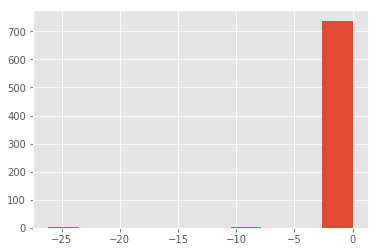

In [110]:
# plot the model error
cdf['ModelError'].hist()


What's the explanation?

Based on some of my comments above, our hypothesis should be that deep in or out of the money options largely have wide bid-ask spreads leading to mis-pricing of the options. Let's plot strike v. model error.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


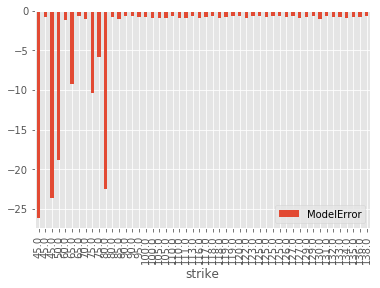

In [111]:
# grab the index of the 50 largest abs(errors)
sorted_errors_idx = cdf['ModelError'].map(abs).sort_values(ascending=False).head(50)

# get the rest of the details from the frame
errors_20_largest_by_strike = cdf.ix[sorted_errors_idx.index]

# plot model error against strike
errors_20_largest_by_strike[['strike', 'ModelError']].sort_values(by='strike').plot(kind='bar', x='strike')


We can also explore how the bid-ask spread contributes to model error.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


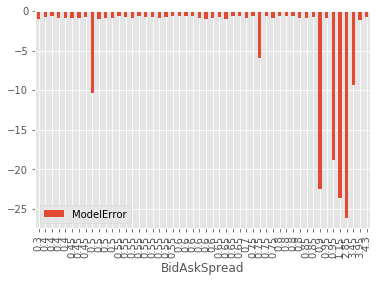

In [112]:
# add a new column
cdf['BidAskSpread'] = cdf['ask'] - cdf['bid']

# plot model error by bid-ask spread
errors_20_largest_by_spread = cdf.ix[sorted_errors_idx.index]

# plot model error against strike, many expirations included
errors_20_largest_by_spread[['BidAskSpread', 'ModelError']].sort_values(by='BidAskSpread').plot(kind='bar', x='BidAskSpread')

In [41]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 30 columns):
Expiration              10 non-null object
option_type             10 non-null object
strike                  10 non-null float64
Symbol                  10 non-null object
Distance OTM            10 non-null float64
stock_price             10 non-null float64
lastPrice               10 non-null float64
bid                     10 non-null float64
ask                     10 non-null float64
change                  10 non-null float64
percentChange           10 non-null float64
volume                  10 non-null float64
openInterest            10 non-null int64
impliedVolatility       10 non-null float64
inTheMoney              10 non-null bool
V/OI                    10 non-null float64
Value                   10 non-null float64
DaysUntilExpiration     10 non-null int64
TimeUntilExpiration     10 non-null float64
InterestRate            10 non-null float64
Mid                     10 n

In [42]:
cdf['DaysUntilExpiration']

0      5
1     12
2     12
3     25
4     47
5    201
6    201
7    201
8    201
9    229
Name: DaysUntilExpiration, dtype: int64

In [51]:
print (cdf[pd.to_numeric(cdf['BidAskSpread'], errors='coerce').isnull()])

Empty DataFrame
Columns: [Expiration, option_type, strike, Symbol, Distance OTM, stock_price, lastPrice, bid, ask, change, percentChange, volume, openInterest, impliedVolatility, inTheMoney, V/OI, Value, DaysUntilExpiration, TimeUntilExpiration, InterestRate, Mid, ImpliedVolatilityMid, TheoreticalValue, Delta, Gamma, Vega, Theta, Rho, ModelError, BidAskSpread]
Index: []

[0 rows x 30 columns]


Finally, let's take a look at the relationship between model error and bid-ask spread.

In [113]:
cdf[abs(cdf['ModelError']) >= 1.0e-10]

,Expiration,option_type,strike,Symbol,Distance OTM,stock_price,lastPrice,bid,ask,change,...,Mid,ImpliedVolatilityMid,TheoreticalValue,Delta,Gamma,Vega,Theta,Rho,ModelError,BidAskSpread
0,2020-12-04,call,105.0,DIS,42.690002,147.690002,42.17,41.40,42.05,0.000000,...,41.725,0.201302,42.690127,1.000000,2.488011e-54,1.294824e-54,-0.000029,0.012445,-9.651269e-01,0.65
1,2020-12-04,call,110.0,DIS,37.690002,147.690002,37.87,36.40,37.10,0.000000,...,36.750,0.201302,37.690133,1.000000,6.001508e-41,3.123337e-41,-0.000030,0.013038,-9.401328e-01,0.70
2,2020-12-04,call,113.0,DIS,34.690002,147.690002,28.55,33.65,34.45,0.000000,...,34.050,0.201302,34.690136,1.000000,4.221394e-34,2.196921e-34,-0.000031,0.013393,-6.401364e-01,0.80
3,2020-12-04,call,116.0,DIS,31.690002,147.690002,28.40,30.50,31.00,0.000000,...,30.750,0.201302,31.690140,1.000000,4.613817e-28,2.401148e-28,-0.000032,0.013749,-9.401399e-01,0.50
4,2020-12-04,call,118.0,DIS,29.690002,147.690002,25.55,28.40,29.15,0.000000,...,28.775,0.201302,29.690142,1.000000,1.857889e-24,9.668928e-25,-0.000032,0.013986,-9.151423e-01,0.75
5,2020-12-04,call,122.0,DIS,25.690002,147.690002,28.80,24.55,25.05,0.000000,...,24.800,0.201302,25.690147,1.000000,3.460018e-18,1.800681e-18,-0.000033,0.014460,-8.901470e-01,0.50
6,2020-12-04,call,123.0,DIS,24.690002,147.690002,19.95,23.60,24.40,0.000000,...,24.000,0.201302,24.690148,1.000000,8.342634e-17,4.341719e-17,-0.000034,0.014579,-6.901482e-01,0.80
7,2020-12-04,call,125.0,DIS,22.690002,147.690002,22.09,21.70,22.30,0.000000,...,22.000,0.201302,22.690151,1.000000,2.986789e-14,1.554401e-14,-0.000034,0.014816,-6.901506e-01,0.60
8,2020-12-04,call,126.0,DIS,21.690002,147.690002,21.68,20.60,21.15,0.000000,...,20.875,0.201302,21.690152,1.000000,4.467451e-13,2.324975e-13,-0.000035,0.014934,-8.151518e-01,0.55
9,2020-12-04,call,127.0,DIS,20.690002,147.690002,20.62,19.55,20.10,0.000000,...,19.825,0.201302,20.690153,1.000000,5.739777e-12,2.987126e-12,-0.000035,0.015053,-8.651530e-01,0.55


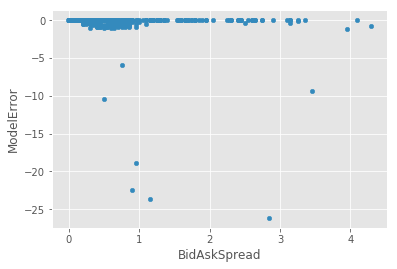

In [114]:
# plot a scatter plot of all errors > 1.0e-4
cdf[abs(cdf['ModelError']) >= 1.0e-10].plot(kind='scatter', x='BidAskSpread', y='ModelError')

There are not enough samples to get any sort of statistical relationship but we can clearly see that as the bid-ask spread increases the model error increases as well.

# Analyzing implied volatility

First we'll look at the so-called implied volatility skew. This plots implied volatility for one expiration across strike prices. Given all else equal, an option with a higher implied volatility will be more expensive. Generally deep in and out of the money strikes command higher prices (and by extension higher implied volatilites) than the Black-Scholes formula implies. This skew only began to appear after the crash of US stocks in October 1987. It is assumed that this is a result of assumptions in the underlying distribution assumption having "fat tails" rather than being completely normal.

Let's take a look.

In [63]:
cdf['Expiration']

0    2020-12-04
1    2020-12-11
2    2020-12-11
3    2020-12-24
4    2021-01-15
5    2021-06-18
6    2021-06-18
7    2021-06-18
8    2021-06-18
9    2021-07-16
Name: Expiration, dtype: object

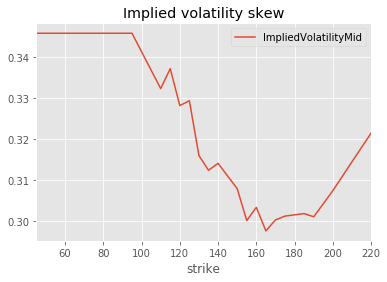

In [115]:
# select an expiration to plot
iv = cdf[cdf['Expiration'] == '2021-06-18']

# get the call options
iv_call = iv[iv['option_type'] == 'call']

# set the strike as the index so pandas plots nicely
iv_call[['strike', 'ImpliedVolatilityMid']].set_index('strike').plot(title='Implied volatility skew')

The curve shows that at the money strikes have a higher implied volatiltiy out the money srikes. This is a bit unusual but very likely due to the general state of market volitlity. Traders are pricing at the money call options much more expensive than out the money call options as a result of the demand for call options at the $130 strike.

In a professional setting, traders would use proprietary models (not simple linear interpolation) to rebuild the curves. If the proprietary model resulted in an implied volatility that was higher than the market, a trade would be executed to exploit the anomaly. In our case, we're simply visualizing the prevailing market state.

Another interesting analysis is to look at the multi-expiration skew chart.

In [116]:
# get the monthly expirations
expirations = cdf['Expiration'].unique()[-5:]


# get all the rows where expiration is in our list of expirations
iv_multi = cdf[cdf['Expiration'].isin(expirations)]
# get the call options
iv_multi_call = iv_multi[iv_multi['option_type'] == 'call']
#iv_multi_call.info()
iv_multi_call[['DaysUntilExpiration','strike','ImpliedVolatilityMid']]


,DaysUntilExpiration,strike,ImpliedVolatilityMid
536,201,45.0,0.345871
537,201,50.0,0.345871
538,201,75.0,0.345871
539,201,80.0,0.345871
540,201,95.0,0.345871
541,201,110.0,0.332358
542,201,115.0,0.337220
543,201,120.0,0.328202
544,201,125.0,0.329391
545,201,130.0,0.315994


In [85]:
iv_multi_call[['DaysUntilExpiration','strike','ImpliedVolatilityMid']].pivot(index='strike', columns='DaysUntilExpiration', values='ImpliedVolatilityMid')

DaysUntilExpiration,12,25,47,201,229
strike,,,,,
140.0,NaN,NaN,NaN,0.328689,NaN
150.0,NaN,0.313624,NaN,NaN,NaN
155.0,NaN,NaN,NaN,0.311726,NaN
160.0,0.377747,NaN,NaN,NaN,NaN
180.0,NaN,NaN,NaN,0.306685,NaN
190.0,NaN,NaN,0.386472,NaN,NaN
200.0,NaN,NaN,NaN,0.309333,NaN
210.0,NaN,NaN,NaN,NaN,0.310293


In [119]:




# pivot the data frame to put expiration dates as columns
iv_pivoted = iv_multi_call[['DaysUntilExpiration', 'strike', 'ImpliedVolatilityMid']].pivot(index='strike', columns='DaysUntilExpiration', values='ImpliedVolatilityMid').dropna()

iv_pivoted

DaysUntilExpiration,201,229,418,565,782
strike,,,,,
150.0,0.307913,0.302070,0.298676,0.302437,0.298049
160.0,0.303353,0.294993,0.296692,0.296547,0.293091
185.0,0.301825,0.296192,0.291865,0.289770,0.289199
210.0,0.314488,0.310046,0.292696,0.294483,0.298950
220.0,0.321484,0.313800,0.296900,0.302158,0.300271


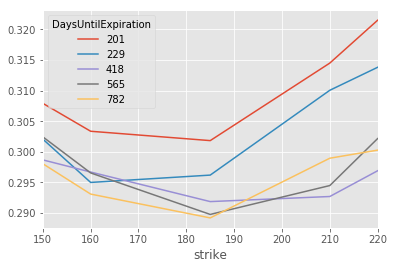

In [120]:
# plot
iv_pivoted.plot()


We'll take a look now at the term structure of volatility. This measures implied volatility at a given strike (usually an at the money strike) but across expirations. Similar to the concept of backwardization and contango in the futures markets, the term structure gives an idea of the demand for options at a particular time in the future.

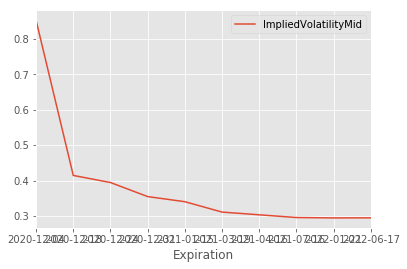

In [121]:
# select a strike to plot
iv = cdf[cdf['strike'] == 180.0]

# get the call options
iv_call = iv[iv['option_type'] == 'call']

# set the strike as the index so pandas plots nicely
iv_call[['Expiration', 'ImpliedVolatilityMid']].set_index('Expiration').plot()

This is a clear demonstration of a violation of the Black-Scholes model assuptions. A flat volatility term structure does not exist in the markets and we have the empirical evidence to prove it.

At the $130 strike, implied is very high at very near expirations. This is a result of the recent market volatility which has increased demand for this option.

One last thing to do is plot the famous volatility surface. This gives a three dimentional representation of the implied volatility against strike price and expiration. While it is sometimes hard to glean any tradeable insight from the surface directly, building surfaces is important to value other derivatives that may not have an exact strike and expiration. This usually happens in the institutional setting however so professional traders can devise their own volatility models and use the implied volatility surface to understand if options are cheap or expensive.

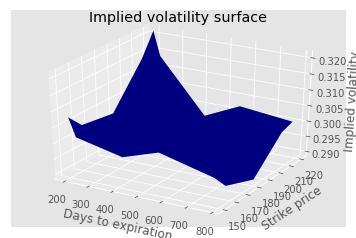

In [122]:
# pivot the dataframe
iv_pivoted_surface = iv_multi_call[['DaysUntilExpiration', 'strike', 'ImpliedVolatilityMid']].pivot(index='strike', columns='DaysUntilExpiration', values='ImpliedVolatilityMid').dropna()

# create the figure object
fig = plt.figure()

# add the subplot with projection argument
ax = fig.add_subplot(111, projection='3d')

# get the 1d values from the pivoted dataframe
x, y, z = iv_pivoted_surface.columns.values, iv_pivoted_surface.index.values, iv_pivoted_surface.values

# return coordinate matrices from coordinate vectors
X, Y = np.meshgrid(x, y)

# set labels
ax.set_xlabel('Days to expiration')
ax.set_ylabel('Strike price')
ax.set_zlabel('Implied volatility')
ax.set_title('Implied volatility surface')

# plot
ax.plot_surface(X, Y, z, rstride=4, cstride=4, color='b')


# Conlusion

This talk was meant to introduce the concept of implied volatility which is an unobserved, but important, input into pricing models. Before we were able to discuss implied volatility, we needed an introduction to the Black-Scholes model and associated pricing formula. Along the way we reviewed the greeks and understood how the Black-Scholes formula is used practically in the markets.

In addition to the theory and math behind the models, we learned how to code it all in Python relying heavily on `Pandas` to gather and manipulate data and `NumPy` and `SciPy` to implement some of the models.

# References

* http://pandas.pydata.org/pandas-docs/stable/index.html
* http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.brentq.html
* http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.interp1d.html
* http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.meshgrid.html
* http://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
* http://nbviewer.ipython.org/github/quantopian/qgrid/blob/master/qgrid_demo.ipynb
* http://daringfireball.net/projects/markdown/syntax
* http://www.codecogs.com/latex/eqneditor.php
* http://www.bespokeoptions.com/blog/2015/10/06/implied-volatility-with-c-and-python-pt-1
* http://blog.nag.com/2013/10/implied-volatility-using-pythons-pandas.html
* http://www.888options.com
* https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model
* https://en.wikipedia.org/wiki/Greeks_(finance)
* https://en.wikipedia.org/wiki/Volatility_smile
* http://pythonpodcast.com/scott-sanderson-algorithmic-trading.html
* http://pythonpodcast.com/yves-hilpisch-quant-finance.html